# Feed Forward Neural Networks - Binary classification problem
## by Vesna Pop-Dimitrijoska
---

### FFNN using SMOTE for Imbalanced Classification version 1
---

Dataset:     
1. `heart-data.csv`      

Task:
1. EDA (single и bivariate)     
2. NAN values imputation     
3. Binary classification with Feed Forward Neural Networks for predicting target class 'stroke'

---
# Loading the libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import copy
import os
import pathlib
from collections import Counter

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping, ModelCheckpoint

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# Read the Dataset

In [3]:
org_df = pd.read_csv('/content/heart-data.csv', index_col=0).reset_index(drop=True)
df = org_df.copy()

display(df.head())

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


---
## Encoding Categorical features

In [4]:
cat_cols = list(df.select_dtypes('object').columns)

for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c].values)

---
## Imputing NaN values with Linear Regression

In [5]:
TARGET_COL='stroke'

In [6]:
df_copy = df.copy()

# Removing 'stroke' column, because this is future target
df_copy = df_copy.drop([TARGET_COL], axis=1)

# Spliting the data into two sets: one with NaN 'bmi' values and one without NaN 'bmi' values
train_data = df_copy[df_copy['bmi'].notnull()]
test_data = df_copy[df_copy['bmi'].isnull()]

x_train = train_data.drop(['bmi'], axis=1)
y_train = train_data['bmi']
x_test = test_data.drop(['bmi'], axis=1)

model = LinearRegression()
model.fit(x_train, y_train)

predicted_bmi = model.predict(x_test)

# Filling NaN values in 'bmi' column with the predicted values
df_copy.loc[df_copy['bmi'].isnull(), 'bmi'] = predicted_bmi

# Add 'stroke' column back to the DataFrame
df['bmi'] = df_copy['bmi']

---
# Feed Forward Neural Network - Binary classification model

In [7]:
X = df.drop(columns=[TARGET_COL])
Y = df[TARGET_COL]

## SMOTE for Imbalanced Classification

In [8]:
print('Shape before SMOTE oversampling', Y.shape)

Shape before SMOTE oversampling (5110,)


In [9]:
# The dataset is transformed using SMOTE method, by oversampling of the minority class 
# to balance the class distribution in a dataset.

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

In [11]:
print('Shape after SMOTE oversampling', Y.shape)

Shape after SMOTE oversampling (9722,)


## Train – Validation – Test  stratified splits and scaling

In [12]:
def split_and_scale(df: pd.DataFrame):

    X_train, X_vt, Y_train, Y_vt = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=SEED, stratify = Y)

    assert X_train.shape[0] == Y_train.shape[0]
    assert X_vt.shape[0]    == Y_vt.shape[0]
    assert X_train.shape[1] == X_vt.shape[1]


    X_val, X_test, Y_val, Y_test = train_test_split(X_vt, Y_vt, test_size=0.5, shuffle=True, random_state=SEED, stratify = Y_vt)

    assert X_val.shape[0]   == Y_val.shape[0]
    assert X_test.shape[0]  == Y_test.shape[0]
    assert X_val.shape[1]   == X_test.shape[1]


    X_train = MinMaxScaler().fit_transform(X_train)
    X_val   = MinMaxScaler().fit_transform(X_val)
    X_test  = MinMaxScaler().fit_transform(X_test)

    return X_train, Y_train.to_numpy(), X_val, Y_val.to_numpy(), X_test, Y_test.to_numpy()

## Model definition and optimization process

In [13]:
def make_and_compile_model(hyper_params: dict, show_summary: bool = False) -> Sequential:

    model = Sequential()

    # INPUT LAYER
    model.add(Input(hyper_params['input_size']))

    # HIDDEN LAYERS
    for hu, ac, dp, bn, kr in zip(  hyper_params['h_layers'],
                                    hyper_params['activations'],
                                    hyper_params['dropout_size'],
                                    hyper_params['batch_normalization'],
                                    hyper_params['kernel_regularizers'],
                                    ):
        if kr is None:
            model.add(Dense(hu, activation=ac))
        else:
            model.add(Dense(hu, activation=ac, kernel_regularizer=kr))
        if bn:
            model.add(BatchNormalization())
        if dp > 0.0:
            model.add(Dropout(dp))

    # OUTPUT LAYER
    model.add(Dense(hyper_params['output_size'], activation=hyper_params['output_activation']))

    if show_summary:
        model.summary()

    model.compile(loss=hyper_params['loss'], optimizer=hyper_params['optimizer'], metrics=hyper_params['metrics'])

    return model

## Training the model

In [14]:
def train_model(model, model_name, X_train, Y_train, X_val, Y_val, quiet=False):

    es_cbk = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    #chp_cbk = ModelCheckpoint(monitor='val_loss', filepath=os.path.join('models', model_name), save_best_only=True)

    model_history = model.fit(X_train,
                            Y_train,
                            epochs=1000,
                            batch_size = 128, # 16, 32, 64, 128, 256,
                            validation_data = (X_val, Y_val),
                            callbacks = [es_cbk],  #, chp_cbk],
                            shuffle=True,
                            verbose=0 if quiet else 1
                            )
    return model_history

In [15]:
def learning_curve(model_history, model_name):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.plot(title=f'Loss learning curve ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()

## Model prediction and model evaluation


In [16]:
def test_eval_model(model, model_name, X_test, Y_test) -> dict:

    Y_pred_probability = model.predict(X_test, verbose=0)

    Threshold = 0.5   # OPTION 1
#   Threshold = 0.4   # OPTION 2
#   Threshold = 0.3   # OPTION 3
#   Threshold = 0.2   # OPTION 4

    Y_pred = (Y_pred_probability >= Threshold).astype(int)

    eval_dict = {
      'Model name:': model_name,
      'F1 score (macro)  (%):': round((f1_score(Y_test, Y_pred, average='macro'))*100, 3),
      'F1 score (binary) (%):': round((f1_score(Y_test, Y_pred, average='binary'))*100, 3),
      'Accuracy          (%):': round((accuracy_score(Y_test, Y_pred))*100, 3),
      'Precision score   (%):': round((precision_score(Y_test, Y_pred))*100, 3),
      'Recall score      (%):': round((recall_score(Y_test, Y_pred))*100, 3),
      'Confusion Matrix     :': confusion_matrix(Y_test, Y_pred)
      }

    display(pd.DataFrame.from_dict(eval_dict, orient='index'))

    ClassificationReport = pd.DataFrame(classification_report(Y_test, Y_pred, output_dict=True)).transpose()
    ClassificationReport.index.name = 'Classification Report'
    display(ClassificationReport)

    return eval_dict

In [17]:
def model_loop(hyper_params: dict, df: pd.DataFrame, model_name: str):
    print("1. Getting and splitting data...", end=' ')
    X_train, Y_train, X_val, Y_val, X_test, Y_test = split_and_scale(df)
    print("Done!")

    print("2. Creating and compiling model...", end=' ')
    model = make_and_compile_model(hyper_params, show_summary=False)
    print("Done!")

    print("3. Training model...", end=' ')
    model_history = train_model(model, model_name, X_train, Y_train, X_val, Y_val, quiet=True)
    print("Done!")

    print("4. Validating and evaluating model...", end=' ')
    learning_curve(model_history, model_name)
    metrics_dict = test_eval_model(model, model_name, X_test, Y_test)
    print("Done!")
    print("---------------------------------------------------------------------------------------\n\n")
    return metrics_dict


Model name:  Baseline_model
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

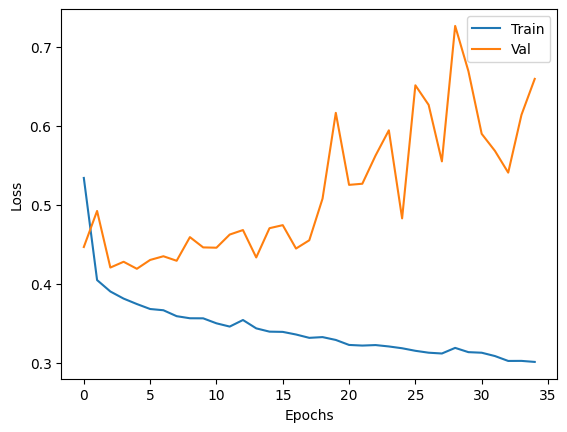

,0
Model name:,Baseline_model
F1 score (macro) (%):,82.733
F1 score (binary) (%):,82.609
Accuracy (%):,82.734
Precision score (%):,83.125
Recall score (%):,82.099
Confusion Matrix :,"[[406, 81], [87, 399]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.823529,0.833676,0.828571,487.000000
1,0.831250,0.820988,0.826087,486.000000
accuracy,0.827338,0.827338,0.827338,0.827338
macro avg,0.827390,0.827332,0.827329,973.000000
weighted avg,0.827386,0.827338,0.827330,973.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp1_5Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

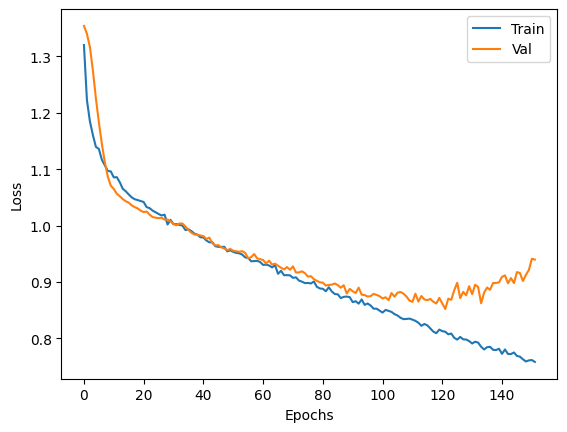

,0
Model name:,Exp1_5Layers
F1 score (macro) (%):,83.144
F1 score (binary) (%):,83.231
Accuracy (%):,83.145
Precision score (%):,82.724
Recall score (%):,83.745
Confusion Matrix :,"[[402, 85], [79, 407]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.835759,0.825462,0.830579,487.000000
1,0.827236,0.837449,0.832311,486.000000
accuracy,0.831449,0.831449,0.831449,0.831449
macro avg,0.831497,0.831455,0.831445,973.000000
weighted avg,0.831502,0.831449,0.831444,973.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp2_5Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

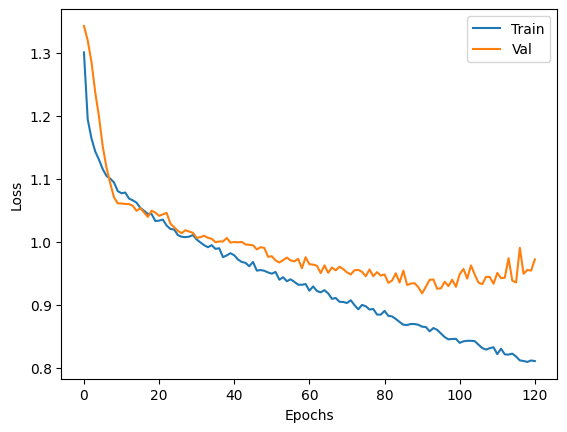

,0
Model name:,Exp2_5Layers
F1 score (macro) (%):,81.805
F1 score (binary) (%):,81.543
Accuracy (%):,81.809
Precision score (%):,82.664
Recall score (%):,80.453
Confusion Matrix :,"[[405, 82], [95, 391]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.810000,0.831622,0.820669,487.000000
1,0.826638,0.804527,0.815433,486.000000
accuracy,0.818088,0.818088,0.818088,0.818088
macro avg,0.818319,0.818074,0.818051,973.000000
weighted avg,0.818311,0.818088,0.818053,973.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp3_6Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

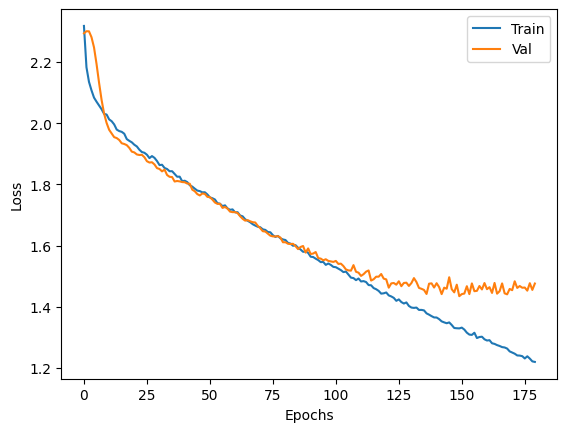

,0
Model name:,Exp3_6Layers
F1 score (macro) (%):,81.445
F1 score (binary) (%):,80.435
Accuracy (%):,81.501
Precision score (%):,85.253
Recall score (%):,76.132
Confusion Matrix :,"[[423, 64], [116, 370]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.784787,0.868583,0.824561,487.000000
1,0.852535,0.761317,0.804348,486.000000
accuracy,0.815005,0.815005,0.815005,0.815005
macro avg,0.818661,0.814950,0.814455,973.000000
weighted avg,0.818626,0.815005,0.814465,973.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp4_6Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

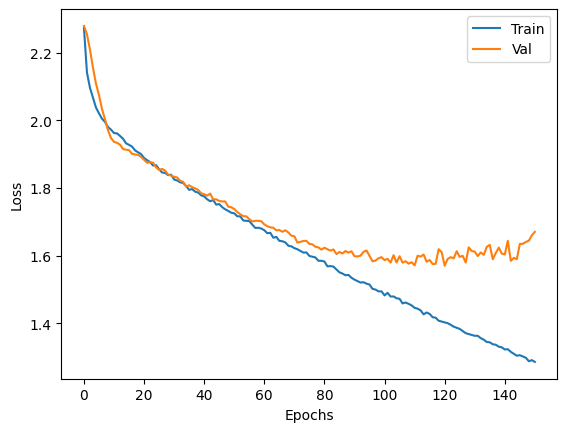

,0
Model name:,Exp4_6Layers
F1 score (macro) (%):,78.78
F1 score (binary) (%):,76.992
Accuracy (%):,78.931
Precision score (%):,84.691
Recall score (%):,70.576
Confusion Matrix :,"[[425, 62], [143, 343]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.748239,0.872690,0.805687,487.000000
1,0.846914,0.705761,0.769921,486.000000
accuracy,0.789311,0.789311,0.789311,0.789311
macro avg,0.797577,0.789226,0.787804,973.000000
weighted avg,0.797526,0.789311,0.787823,973.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp5_NO_bn
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

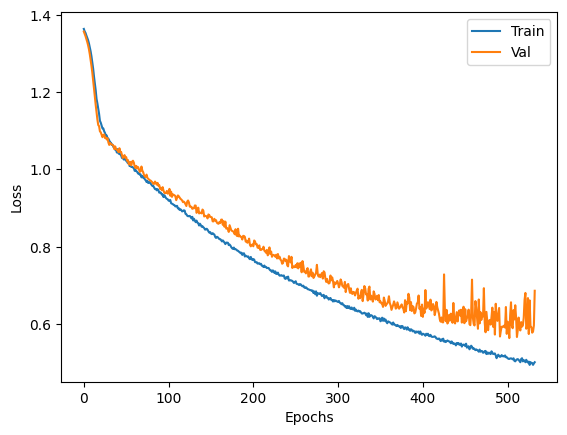

,0
Model name:,Exp5_NO_bn
F1 score (macro) (%):,83.741
F1 score (binary) (%):,84.325
Accuracy (%):,83.762
Precision score (%):,81.418
Recall score (%):,87.449
Confusion Matrix :,"[[390, 97], [61, 425]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.864745,0.800821,0.831557,487.000000
1,0.814176,0.874486,0.843254,486.000000
accuracy,0.837616,0.837616,0.837616,0.837616
macro avg,0.839461,0.837653,0.837405,973.000000
weighted avg,0.839487,0.837616,0.837399,973.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp6_NO_dp
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

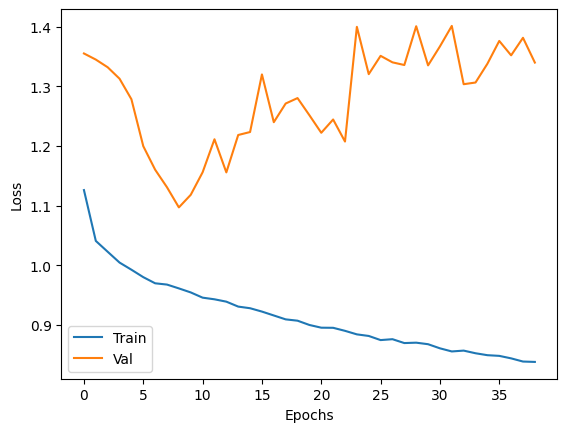

,0
Model name:,Exp6_NO_dp
F1 score (macro) (%):,80.88
F1 score (binary) (%):,80.625
Accuracy (%):,80.884
Precision score (%):,81.646
Recall score (%):,79.63
Confusion Matrix :,"[[400, 87], [99, 387]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.801603,0.821355,0.811359,487.000000
1,0.816456,0.796296,0.806250,486.000000
accuracy,0.808839,0.808839,0.808839,0.808839
macro avg,0.809029,0.808826,0.808805,973.000000
weighted avg,0.809022,0.808839,0.808807,973.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp7_NO_kr
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

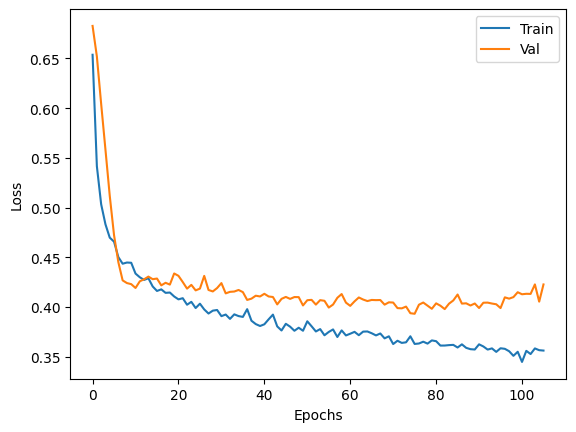

,0
Model name:,Exp7_NO_kr
F1 score (macro) (%):,82.829
F1 score (binary) (%):,82.476
Accuracy (%):,82.837
Precision score (%):,84.154
Recall score (%):,80.864
Confusion Matrix :,"[[413, 74], [93, 393]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.816206,0.848049,0.831823,487.000000
1,0.841542,0.808642,0.824764,486.000000
accuracy,0.828366,0.828366,0.828366,0.828366
macro avg,0.828874,0.828346,0.828293,973.000000
weighted avg,0.828861,0.828366,0.828297,973.000000


Done!
---------------------------------------------------------------------------------------




In [18]:
grid_dict = {
    'Baseline_model': {
        'input_size': X.shape[1],

        'h_layers': [256, 64, 16],
        'activations': ['relu', 'relu', 'relu'],
        'dropout_size': [0, 0, 0],
        'batch_normalization': [False, False, False],
        'kernel_regularizers': [None, None] * 3,

        'output_size': 1,
        'output_activation': 'sigmoid',


        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp1_5Layers': {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp2_5Layers': {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp3_6Layers': {
        'input_size': X.shape[1],

        'h_layers': [512, 256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.25, 0.2, 0.3, 0.25, 0.2, 0.3],
        'batch_normalization': [True, True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 6,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp4_6Layers': {
        'input_size': X.shape[1],

        'h_layers': [512, 256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.1, 0.15, 0.2, 0.1],
        'batch_normalization': [True, True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 6,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp5_NO_bn': {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [False, False, False, False, False],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


    'Exp6_NO_dp': {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0, 0, 0, 0, 0],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


    'Exp7_NO_kr':  {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.20, 0.15, 0.20, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [None, None] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }
}

eval_results = []
for model_name, hyper_d in grid_dict.items():
    print('\nModel name: ', model_name)
    print('----------------------------------------')
    eval_results.append(model_loop(hyper_d, df, model_name))

# RESULTS

In [19]:
pd.DataFrame(eval_results)

,Model name:,F1 score (macro) (%):,F1 score (binary) (%):,Accuracy (%):,Precision score (%):,Recall score (%):,Confusion Matrix :
0,Baseline_model,82.733,82.609,82.734,83.125,82.099,"[[406, 81], [87, 399]]"
1,Exp1_5Layers,83.144,83.231,83.145,82.724,83.745,"[[402, 85], [79, 407]]"
2,Exp2_5Layers,81.805,81.543,81.809,82.664,80.453,"[[405, 82], [95, 391]]"
3,Exp3_6Layers,81.445,80.435,81.501,85.253,76.132,"[[423, 64], [116, 370]]"
4,Exp4_6Layers,78.780,76.992,78.931,84.691,70.576,"[[425, 62], [143, 343]]"
5,Exp5_NO_bn,83.741,84.325,83.762,81.418,87.449,"[[390, 97], [61, 425]]"
6,Exp6_NO_dp,80.880,80.625,80.884,81.646,79.630,"[[400, 87], [99, 387]]"
7,Exp7_NO_kr,82.829,82.476,82.837,84.154,80.864,"[[413, 74], [93, 393]]"


#### CONCLUSION:     
Significant improvment was made using the SMOTE technique for  balancing the class distribution in a dataset. SMOTE generates synthetic samples in order to balance the classes, which can lead to better performance of a machine learning model, especially in cases where the minority class is important.
